# Getting the data and importing the libraries 

In [1]:
!pip install transformers
!git clone https://github.com/Henya14/deep-learning-ner.git
!cp -R ./deep-learning-ner/data ./data
!cp -R ./deep-learning-ner/training.py ./

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 16.2 MB/s 
     |████████████████████████████████| 182 kB 48.8 MB/s 
     |████████████████████████████████| 7.6 MB 32.9 MB/s 
Cloning into 'deep-learning-ner'...
remote: Enumerating objects: 2150, done.
remote: Counting objects: 100% (2150/2150), done.
remote: Compressing objects: 100% (827/827), done.
remote: Total 2150 (delta 886), reused 2053 (delta 806), pack-reused 0
Receiving objects: 100% (2150/2150), 25.44 MiB | 6.60 MiB/s, done.
Resolving deltas: 100% (886/886), done.


In [2]:
from training import get_dfs, train_test_devel_data_path
import pandas as pd
import matplotlib.pyplot as plt

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/272k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

# Loading the data

Here I create new sentences from the tokens in the train df that are not tagged as other(O)

In [3]:
dfs = get_dfs()
train_no_O_tags_df = dfs["train"].copy()
train_no_O_tags_df = train_no_O_tags_df[dfs["train"]["CONLL:NER"] != "O"]
max_sentence_index =  dfs["train"]["sentence_index"].max()
train_no_O_tags_df["sentence_index"] = train_no_O_tags_df["sentence_index"] + max_sentence_index + 1


Loading: data/train-devel-test/train/legal/no-morph
Loading: data/train-devel-test/train/wikipedia/no-morph
Loading: data/train-devel-test/train/news/no-morph
Loading: data/train-devel-test/train/fiction/no-morph
Loading: data/train-devel-test/devel/legal/no-morph
Loading: data/train-devel-test/devel/news/no-morph
Loading: data/train-devel-test/devel/fiction/no-morph
Loading: data/train-devel-test/test/legal/no-morph
Loading: data/train-devel-test/test/news/no-morph
Loading: data/train-devel-test/test/fiction/no-morph


<ipython-input-3-0b09b07086a7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_O_tags_df["sentence_index"] = train_no_O_tags_df["sentence_index"] + max_sentence_index + 1


Here I create a df that contains all the original tokens and the non-O tags in the new sentences

In [4]:
all_df = pd.concat([dfs["train"],train_no_O_tags_df])
all_df

,sentence_index,position_number_in_sentence,FORM,LEMMA,UPOS,XPOS,FEATS,CONLL:NER,train_test_devel,genre,file_path
0,0,0,A,_,_,_,_,O,train,legal,data\train-devel-test\train\legal\no-morph\con...
1,0,1,Bizottság,_,_,_,_,B-ORG,train,legal,data\train-devel-test\train\legal\no-morph\con...
2,0,2,továbbá,_,_,_,_,O,train,legal,data\train-devel-test\train\legal\no-morph\con...
3,0,3,megküldi,_,_,_,_,O,train,legal,data\train-devel-test\train\legal\no-morph\con...
4,0,4,számukra,_,_,_,_,O,train,legal,data\train-devel-test\train\legal\no-morph\con...
...,...,...,...,...,...,...,...,...,...,...,...
637720,85765,2,Északi,_,_,_,_,B-LOC,train,fiction,data\train-devel-test\train\fiction\no-morph\t...
637721,85765,3,sarkon,_,_,_,_,I-LOC,train,fiction,data\train-devel-test\train\fiction\no-morph\t...
637765,85769,1,Karcsi,_,_,_,_,B-PER,train,fiction,data\train-devel-test\train\fiction\no-morph\t...
637820,85774,8,Karcsi,_,_,_,_,B-PER,train,fiction,data\train-devel-test\train\fiction\no-morph\t...


# Getting the sentences

This is the reworked `get_sentences` function from `training.py` that returns a pandas `DataFrame` with the sentences instead

In [5]:
from tqdm import tqdm
def get_sentences(df: pd.DataFrame):
    copy_df = df.copy()
    copy_df = copy_df.sort_values(["sentence_index", "position_number_in_sentence"])
    sentences = pd.DataFrame(columns=["FORM", "TAG"] )
    print(f"There are {len(copy_df['sentence_index'].unique())} sentences in the dataset")
    for i in tqdm(range(copy_df["sentence_index"].max())):
        form_tag_pairs = copy_df[copy_df["sentence_index"]==i][["sentence_index","position_number_in_sentence", "FORM", "CONLL:NER"]]
        if (len(form_tag_pairs) > 0):
            row = {
                    "FORM": form_tag_pairs["FORM"].tolist(),
                    "TAG": form_tag_pairs["CONLL:NER"].tolist(),
                }
            row = pd.Series(row)
            sentences.loc[len(sentences)] = row
            #sentences.append({"FORM": form_tag_pairs["FORM"].tolist(),"TAG": form_tag_pairs["CONLL:NER"].tolist()})
        
    return sentences

In [6]:
train_sentence_df = get_sentences(all_df)

There are 63532 sentences in the dataset


100%|██████████| 85775/85775 [07:43<00:00, 185.24it/s]


Here I get the original sentences and the sentences without the O tag

In [7]:
original_sentences_df = train_sentence_df[:42884].copy()
sentences_without_O_tag_df = train_sentence_df[42884:].copy()

Here I remove the duplicate sentences from the non-O sentences. I needed to use a little hack because `drop_duplicates` does not work on lists so the data fram had to be converted to string and then drop the duplicates. 

In [8]:
sentences_without_O_tag_df = sentences_without_O_tag_df.loc[sentences_without_O_tag_df.astype(str).drop_duplicates().index]

In [9]:
sentences_without_O_tag_df

,FORM,TAG
42884,"[Bizottság, Unió]","[B-ORG, B-ORG]"
42885,"[Európai, Parlament, Európai, Tanácsban, Tanác...","[B-ORG, I-ORG, B-ORG, I-ORG, B-ORG, B-ORG, I-O..."
42886,"[Európai, Regionális, Fejlesztési, Alapra]","[B-ORG, I-ORG, I-ORG, I-ORG]"
42887,"[Tanácsnak, Unió]","[B-ORG, B-ORG]"
42888,"[Tanács, Unió, Európai, Parlamenttel, Bizottság]","[B-ORG, B-ORG, B-ORG, I-ORG, B-ORG]"
...,...,...
63517,"[Sándor, Karcsi]","[B-PER, I-PER]"
63518,[Karcsiban],[B-PER]
63520,[Keszegnek],[B-PER]
63524,[Hercegre],[B-PER]


Here I save each data frame, beacause getting the sentences takes a lot of time and this way it will be quicker to load them before use.

In [10]:
sentences_without_O_tag_df.to_csv("removed_o_tag_sentences.csv", index=False)

In [11]:
original_sentences_df.to_csv("original_sentences.csv", index=False)

# Augmenting the train dataset

Here I define the data frame augmentation function that adds the non-O tag sentences the specified amount of times to the original sentences

In [12]:
import os
def get_augmented_train_df(add_no_o_tag_sentences_num_times = 1): 
    train_df = pd.read_csv(os.path.join(train_test_devel_data_path, "train", "original_sentences.csv"))
    train_sentences_removed_o_tag_df =  pd.read_csv(os.path.join(train_test_devel_data_path, "train", "removed_o_tag_sentences.csv"))
    for i in range(add_no_o_tag_sentences_num_times):
        train_df = pd.concat([train_df, train_sentences_removed_o_tag_df], ignore_index=True)
    return train_df


Here I check how the augmentation changed the tag distribution

The data frame's 87.58% is tagged as O


<BarContainer object of 9 artists>

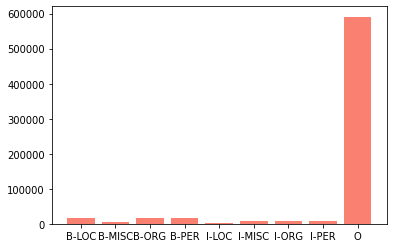

In [13]:
from collections import Counter


augmented_train_df = get_augmented_train_df(1)
tags = augmented_train_df["TAG"].apply(eval).tolist()
tags = [item for item_list in tags for item in item_list]
value_counts= pd.Series(Counter(tags)).sort_index()
print(f"The data frame's {value_counts['O']/ value_counts.sum() * 100:.2f}% is tagged as O")
plt.bar(value_counts.keys(), value_counts.values, color="salmon", label="# of tags")